# Variational Auto Encoder 2 - Fashion MNIST

1. Data load
2. Hyperparameters
3. Encoder
4. Sampling function and latent layer
5. Decoder
6. Loss
7. Build models
8. Train model
9. Plot loss
10. Plot 2D latent space
11. Compare x and x^
12. Display a 2D manifold


In [30]:
import numpy as np
import matplotlib.pyplot as plt

from tensorflow.keras.datasets import fashion_mnist
from tensorflow.keras.layers import Input, Dense, Lambda
from tensorflow.keras.models import Model
from tensorflow.keras import backend as K
from tensorflow.keras import losses

## 1. Hyperparameters

In [31]:
z_dim = 2
h_size = 512
img_size = 28*28*1
batchsize = 32
epochs = 100

## 2. Data load

In [32]:
(x_train, y_train), (x_test, y_test) = fashion_mnist.load_data()
x_train = x_train.astype(np.float32) / 255
x_test = x_test.astype(np.float32) / 255
x_train = np.reshape(x_train, (x_train.shape[0], img_size))
x_test = np.reshape(x_test, (x_test.shape[0], img_size))
print('x_train shape:', x_train.shape)
print('x_test shape:', x_test.shape)

x_train shape: (60000, 784)
x_test shape: (10000, 784)


## 3. Encoder

In [33]:
enc_inputs = Input(shape=(img_size,))
enc_h1 = Dense(h_size, activation='relu')(enc_inputs)
enc_h2 = Dense(h_size / 2, activation='relu')(enc_h1)
enc_h3 = Dense(h_size / 4, activation='relu')(enc_h2)
mu = Dense(z_dim)(enc_h3)
sigma = Dense(z_dim)(enc_h3)

## 4. Sampling function and latent layer

In [34]:
def sampling_z(args):
    mu, sigma = args
    eps = K.random_normal(shape=(batchsize, z_dim,), mean=0., stddev=1.)
    return mu + K.exp(sigma) * eps

z = Lambda(sampling_z, output_shape=(z_dim,))([mu, sigma])

## 5. Decoder

In [35]:
dec_h1 = Dense(h_size / 4, activation='relu')
dec_h2 = Dense(h_size / 2, activation='relu')
dec_h3 = Dense(h_size, activation='relu')
dec_outputs = Dense(img_size, activation='sigmoid')

vae_decoder = dec_h1(z)
vae_decoder = dec_h2(vae_decoder)
vae_decoder = dec_h3(vae_decoder)
vae_outputs = dec_outputs(vae_decoder)



## 6. Loss

In [36]:
def loss(enc_inpupts, vae_outputs):
    reconstruction_loss = losses.binary_crossentropy(enc_inpupts, vae_outputs)
    reconstruction_loss *= 784
    kl_loss = .5 * K.sum(K.square(mu) + K.exp(sigma) - sigma - 1, axis=-1)
    return K.mean(reconstruction_loss + kl_loss)

## 7. Build model

In [37]:
vae = Model(enc_inputs, vae_outputs)
vae.summary()
vae.compile(optimizer='rmsprop', loss=loss)

Model: "model_7"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_6 (InputLayer)            [(None, 784)]        0                                            
__________________________________________________________________________________________________
dense_14 (Dense)                (None, 512)          401920      input_6[0][0]                    
__________________________________________________________________________________________________
dense_15 (Dense)                (None, 256)          131328      dense_14[0][0]                   
__________________________________________________________________________________________________
dense_16 (Dense)                (None, 128)          32896       dense_15[0][0]                   
____________________________________________________________________________________________

## 8. Train model

In [38]:
history = vae.fit(x_train,
                  x_train,
                  shuffle=True,
                  epochs=epochs,
                  batch_size=batchsize,
                  verbose=1
                 )

Train on 60000 samples
Epoch 1/100
60000/60000 [==============================] - 5s 81us/sample - loss: 279.7312
Epoch 2/100
60000/60000 [==============================] - 5s 76us/sample - loss: 262.3166
Epoch 3/100
60000/60000 [==============================] - 5s 82us/sample - loss: 260.0451
Epoch 4/100
60000/60000 [==============================] - 5s 82us/sample - loss: 258.5305
Epoch 5/100
60000/60000 [==============================] - 5s 80us/sample - loss: 257.1944
Epoch 6/100
60000/60000 [==============================] - 5s 80us/sample - loss: 256.3925
Epoch 7/100
60000/60000 [==============================] - 5s 83us/sample - loss: 255.5414
Epoch 8/100
60000/60000 [==============================] - 5s 75us/sample - loss: 256.2117
Epoch 9/100
60000/60000 [==============================] - 5s 87us/sample - loss: 256.0403
Epoch 10/100
60000/60000 [==============================] - 5s 81us/sample - loss: 255.1184
Epoch 11/100
60000/60000 [==============================] - 5s 79u

## 9. Plot loss

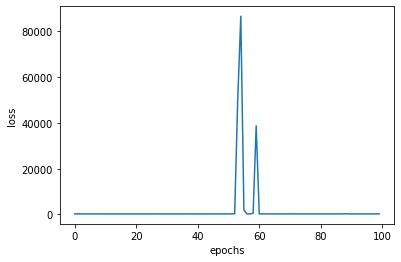

In [39]:
# Plot loss
loss = history.history['loss']
plt.plot(loss)
plt.xlabel('epochs')
plt.ylabel('loss')
plt.show()

## 10. Plot 2D latent space

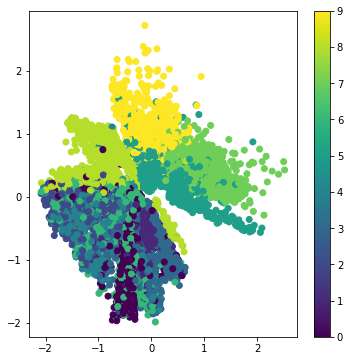

In [40]:
# Build the encoder model
encoder_model = Model(enc_inputs, mu)
# Encode the input images
x_z = encoder_model.predict(x_test)
# Plot the mu latent space
plt.figure(figsize=(6, 6))
plt.scatter(x_z[:, 0], x_z[:, 1], c=y_test)
plt.colorbar()
plt.show()

## 11. Compare x and x_hat

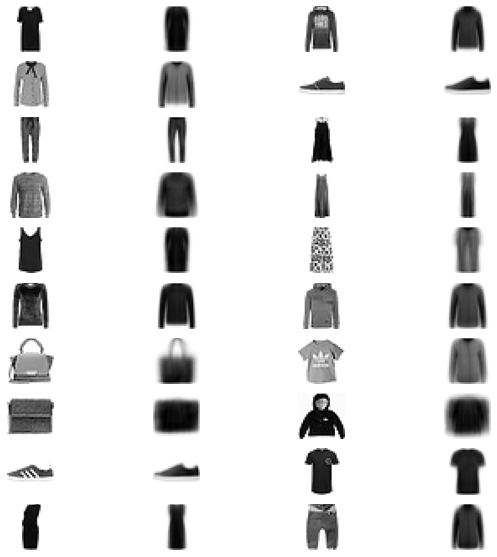

In [41]:
# Forwardpropagate a set of images through the entire vae model
chance = np.random.randint(len(x_test - batchsize))
x = x_test[chance: chance + batchsize]
x_x = vae.predict(x)
x = x[:20]
x_x = x_x[:20]
x = np.reshape(x, (x.shape[0], 28, 28))
x_x = np.reshape(x_x, (x_x.shape[0], 28, 28))
# Plot images
fig = plt.figure(figsize=(10, 10))
counter = 1
for i, j in zip(x, x_x):
    plt.subplot(10, 4, counter)
    plt.axis('off')
    plt.imshow(i[:, :], cmap='gray_r')
    counter += 1
    plt.subplot(10, 4, counter)
    plt.axis('off')
    plt.imshow(j[:, :], cmap='gray_r')
    counter += 1
plt.show()

## 12. Display a 2D manifold

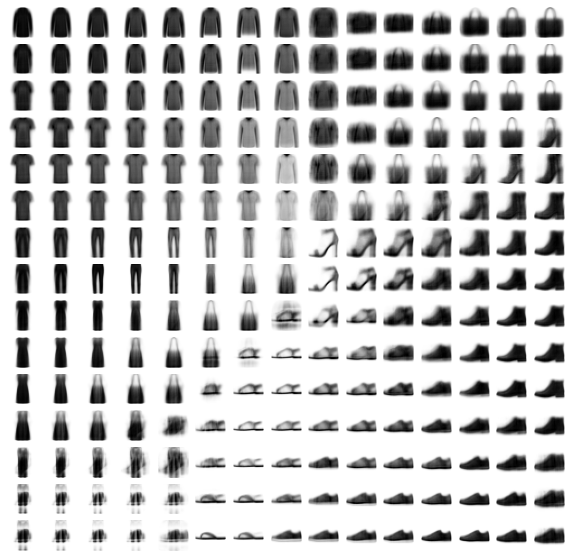

In [48]:
# Build the decoder model
dec_inputs = Input(shape=(z_dim,))
decoder = dec_h1(dec_inputs)
decoder = dec_h2(decoder)
decoder = dec_h3(decoder)
decoder_outputs = dec_outputs(decoder)
decoder_model =  Model(dec_inputs, decoder_outputs)
# Define a grid
n = 15
num_samples = 225
min_range = -1.05
max_range = 1.05
x_grid = np.linspace(min_range, max_range, n)
y_grid = np.linspace(min_range, max_range, n)
_z = []
for i in y_grid:
    for j in x_grid:
        _z.append([i, j])
_z = np.reshape(np.array(_z), (num_samples, 2))
_z.shape
# Display images
x_hat = decoder_model.predict(_z)
x_hat = np.reshape(x_hat, (x_hat.shape[0], 28, 28))
fig = plt.figure(figsize=(10, 10))
for i in range(num_samples):
    img = x_hat[i]
    plt.subplot(n, n, i + 1)
    plt.axis('off')
    plt.imshow(img[:, :], cmap='gray_r')
plt.show()